IMPORTING REQUIRED LIBRARIES

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from imblearn.over_sampling import SMOTE #to handle imbalance -> will decide if required later on


LOADING THE CSV FILE (Customer-Churn.csv)

In [36]:
#making a dataframe
df = pd.read_csv('Customer-Churn.csv')

#showing the top 5 rows
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


CHECKING SHAPE,INFO,NULLS

In [37]:
df.shape
df.info()
df.isnull().sum()  #aggregation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


CLASS BALANCE AND DISTRIBUTION VISUALIZATION

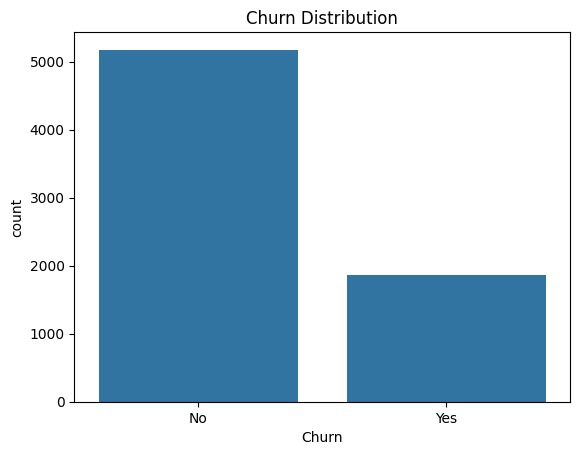

In [38]:
df['Churn'].value_counts(normalize=True)

sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()


DATA CLEANING AND PREPROCESSING

1) CONVERTING WRONG NUMERICAL PROBLEMS:

In [39]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True) --> not working as in pandas 3.0 we dont know if the real dataframe is modified or a temporary copy.

df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())


2) ENCODING CATEGORICAN COLS:

In [40]:
# First, grab all the categorical columns (usually strings / objects)

categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Just in case the target slipped in there, remove it manually:

if 'Churn' in categorical_columns:
    categorical_columns.remove('Churn')

# One-hot encoding for categorical features
# Using drop_first=True to avoid the dummy variable trap
# (although some models don't really care)
df = pd.get_dummies(
    df,
    columns=categorical_columns,
    drop_first=True
)

# Encode the target variable separately
# LabelEncoder is simple enough here since it's just Yes/No

label_enc = LabelEncoder()
df['Churn'] = label_enc.fit_transform(df['Churn'])

# We may want to save label_enc if we acc put this into production.



3) TRAIN-TEST SPLIT:

In [41]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


4) IMBALANCE HANDLING

In [42]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

BASELINE MODEL: LOGISTIC REGRESSION

In [43]:
log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train_sm, y_train_sm)

y_pred_log = log_model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


MODEL EVALUATION FUNCTION:

In [44]:
def evaluate_model(y_true, y_pred):

  """Function to evaluate the performance of a classification model.
Purpose:
Calculate accuracy, precision, recall, F1-score and plot confusion matrix.

Inputs:

y_true: actual labels

y_pred: predicted labels

Outputs:

printed metrics

confusion matrix heatmap"""
  acc = accuracy_score(y_true, y_pred)
  prec = precision_score(y_true, y_pred)
  rec = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)

  print(f"Accuracy:  {acc:.4f}")
  print(f"Precision: {prec:.4f}")
  print(f"Recall:    {rec:.4f}")
  print(f"F1-Score:  {f1:.4f}")

  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()

LOGISTIC REGRESSION EVALUATION:

Logistic Regression Performance:
Accuracy:  0.7559
Precision: 0.5355
Recall:    0.6043
F1-Score:  0.5678


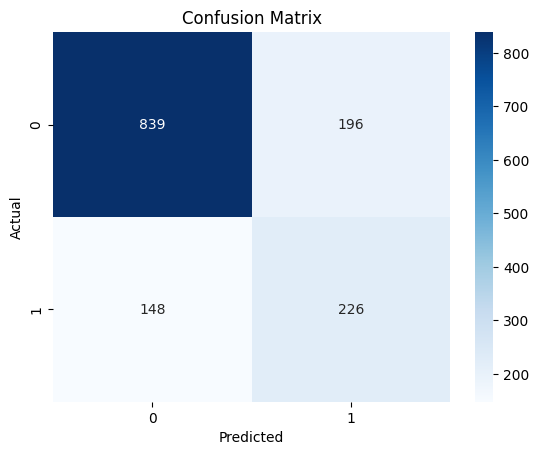

In [45]:
print("Logistic Regression Performance:")
evaluate_model(y_test, y_pred_log)

RANDOM FOREST MODEL (THEORETICALLY BETTER)

In [46]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=42
)

rf.fit(X_train_sm, y_train_sm)

y_pred_rf = rf.predict(X_test)


RANDOM FOREST EVALUATION:

Random Forest Performance:
Accuracy:  0.7211
Precision: 0.4842
Recall:    0.7807
F1-Score:  0.5977


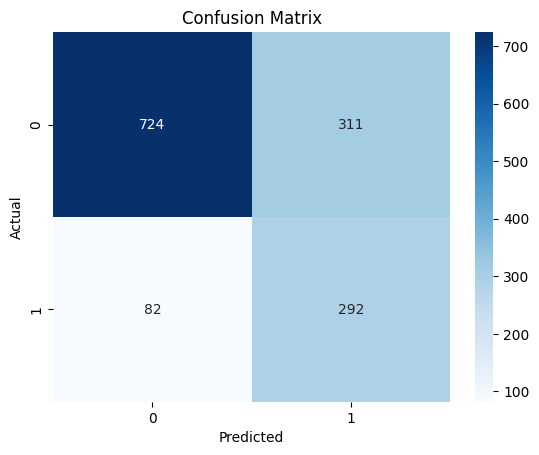

In [47]:
print("Random Forest Performance:")
evaluate_model(y_test, y_pred_rf)

FEATURE IMPORTANCE:

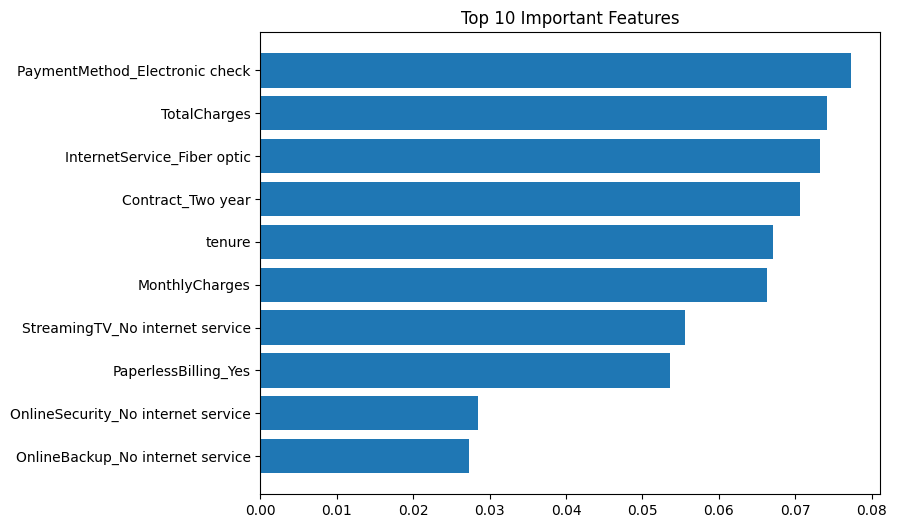

In [48]:
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]  # top 10 features

plt.figure(figsize=(8,6))
plt.barh(range(10), importances[indices])
plt.yticks(range(10), X.columns[indices])
plt.title("Top 10 Important Features")
plt.show()

MAKING A CHURN FINDER API WITH FASTAPI

In [32]:
import joblib, json

joblib.dump(rf, "churn_model.pkl")
json.dump(list(X.columns), open("columns.json", "w"))

